In [6]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from multitest import MultiTest

import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm
import pandas as pd

from survival import *


## Load raw data:

In [20]:
df = pd.read_csv("./Data/SCANB_groups_valid.csv")
gene_names = [c for c in df.columns if c not in ['Unnamed: 0', 'time', 'event']]

div_probs = df.agg(['mean'])
thresh = 0.001
valid_genes = [g for g in gene_names if np.abs(div_probs[g]['mean'] - 0.5) < thresh]
invalid_genes = [g for g in gene_names if np.abs(div_probs[g]['mean'] - 0.5) > thresh]
df.drop(columns = invalid_genes + ['Unnamed: 0'])

assert(len(invalid_genes) == 0)

print("Removed: ", 9259 - len(valid_genes))

Removed:  557


### Ilustrate data

In [148]:
print(reduce_time_resolution(two_groups_gene(df, gene_name), T=100).astype(int).reset_index()\
      .drop(columns=['t','censored1','censored2'])\
      .filter(['at-risk1', 'dead1', 'at-risk2', 'dead2']).head(5)\
        .to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  at-risk1 &  dead1 &  at-risk2 &  dead2 \\
\midrule
0 &      1534 &      0 &      1535 &      1 \\
1 &      1534 &      1 &      1534 &      1 \\
2 &      1533 &      0 &      1533 &      0 \\
3 &      1533 &      2 &      1533 &      1 \\
4 &      1531 &      1 &      1532 &      2 \\
\bottomrule
\end{tabular}



/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_54262/3386803395.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(reduce_time_resolution(two_groups_gene(df, gene_name), T=100).astype(int).reset_index()\


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


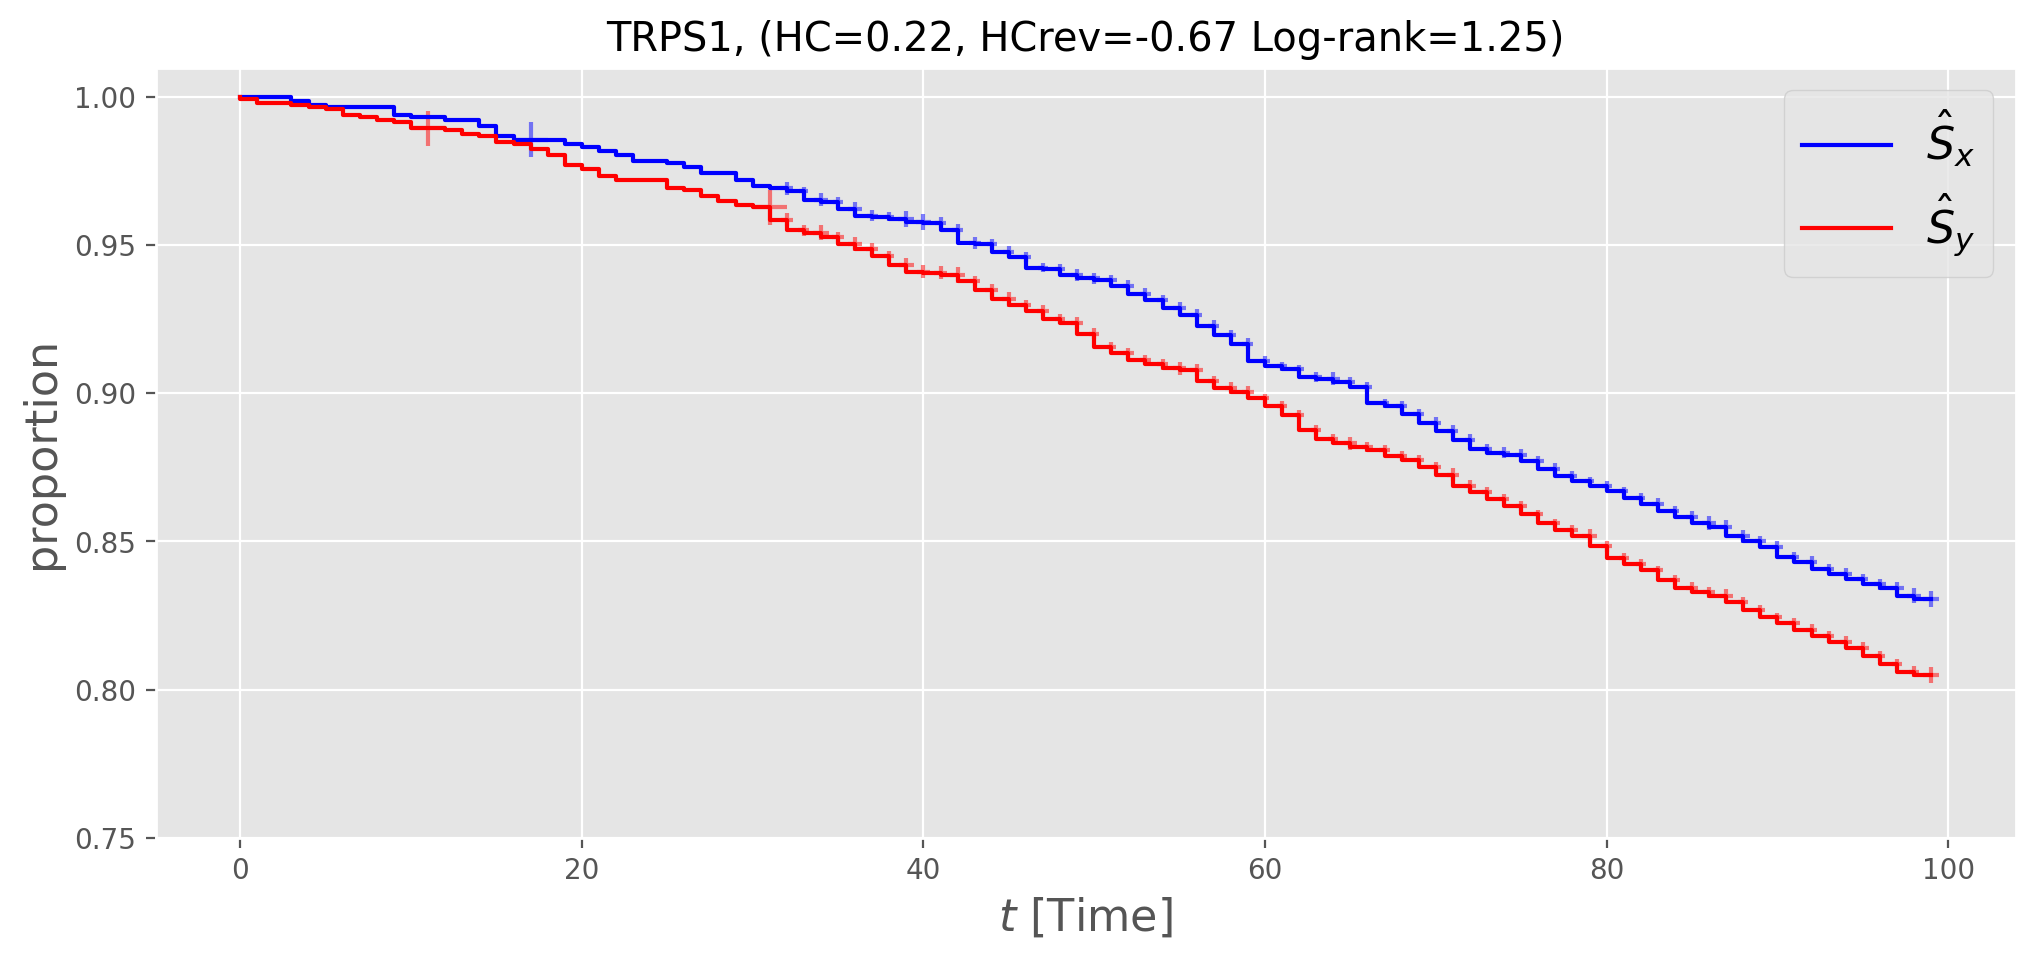

In [29]:
#from illustrate_gene_expression_results import illustrate_survival_curve_gene

from multitest import MultiTest

def find_changes(Nt1, Nt2, Ot1, Ot2, stbl=True, gamma=.5):
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals <= 1], stbl=stbl)
    hc, hct = mt.hc(gamma=gamma)
    return pvals <= hct


def illustrate_survival_curve_gene(df, gene_name, T, stbl=False,
                               show_HCT=True, randomize_HC=False):
    dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)

    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values

    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=randomize_HC)
    stats_rev = evaluate_test_stats(Nt2, Nt1, Ot2, Ot1, stbl=stbl, randomize=randomize_HC)
    if stats['hc_greater'] < stats_rev['hc_greater']:  # reverse groups
        dfg = dfg.rename(columns={'at-risk1': 'at-risk2', 'at-risk2': 'at-risk1',
                                  'dead1': 'dead2', 'dead2': 'dead1',
                                  'censored1': 'censored2', 'censored2': 'censored1'
                                  })
        temp = stats
        stats = stats_rev
        stats_rev = temp

    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values

    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    pvals_rev = multi_pvals(Nt2, Nt1, Ot2, Ot1, randomize=False)
    fpval = find_changes(Nt1, Nt2, Ot1, Ot2, stbl=True)

    dfg['pvalue'] = pvals
    dfg['pvalue_rev'] = pvals_rev
    cumc1 = dfg['censored1'].cumsum()
    cumc2 = dfg['censored2'].cumsum()
    dfg['Survival Proportion X'] = (dfg['at-risk1'] - dfg['censored1']) / (dfg['at-risk1'].max() - cumc1)
    dfg['Survival Proportion Y'] = (dfg['at-risk2'] - dfg['censored2']) / (dfg['at-risk2'].max() - cumc2)
    # dfg['censored1'] = dfg['at-risk1'] - dfg['']

    df_disp = dfg[fpval].rename(columns={'at-risk1': 'at-risk X', 'at-risk2': 'at-risk Y',
                                         'dead1': 'events X', 'dead2': 'events Y'
                                         })

    plt.step(dfg.index, dfg['Survival Proportion X'], 'b', where='pre')
    plt.step(dfg.index, dfg['Survival Proportion Y'], 'r', where='pre')
    ct1 = dfg['censored1'] > 0
    ct2 = dfg['censored2'] > 0
    s1 = 10 * (dfg.loc[ct1, 'censored1'].max() / dfg.loc[ct1, 'censored1']).values
    s2 = 10 * (dfg.loc[ct2, 'censored2'].max() / dfg.loc[ct2, 'censored2']).values
    plt.scatter(dfg.index[ct1], dfg.loc[ct1, 'Survival Proportion X'],
                marker='+', c='b',
                s=s1, alpha=.5)
    plt.scatter(dfg.index[ct2], dfg.loc[ct2, 'Survival Proportion Y'],
                marker='+', c='r',
                s=s2, alpha=.5)

    plt.legend([r'$\hat{S}_x$', r'$\hat{S}_y$'], fontsize=16, loc=1)

    if show_HCT:
        plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.5)

    plt.title(f"{gene_name}, (HC={np.round(stats['hc_greater'],2)}, HCrev={np.round(stats_rev['hc_greater'],2)} Log-rank={np.round(stats['log_rank_greater'],2)})")
    plt.ylabel('proportion', fontsize=16)
    plt.xlabel(r'$t$ [Time]', fontsize=16)
    plt.ylim([0.7, 1.01])

    return df_disp, dfg



plt.rcParams['figure.figsize'] =  [12, 5]
T = 100


for gene_name in tqdm(['TRPS1']):
    dfp, dfg = illustrate_survival_curve_gene(df, gene_name, T, stbl=False, show_HCT=False)
plt.ylim([.75 ,1.01])
#plt.savefig(f"{gene_name}.png")
plt.show()

## Report null values

In [3]:
def infmean(x):
    "mean ignoring inf values"
    return np.mean(np.ma.masked_invalid(x))

def std_95(x):
    return scipy.stats.mstats.mjci(x, prob = [0.95])[0]

def q95(x):
    """
    Compute the 95-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .95)


def infstd(x):
    return np.std(np.ma.masked_invalid(x))


In [4]:
T = 100
M = 100000
stbl = False
df0 = pd.read_csv(f'results/SCNAB_null_{stbl}_T{T}_M{M}.csv')

from test_gene_expression import report_null_stats

report_null_stats(df0, T)

        log_rank_greater  hc_greater      x0      y0      lam
q95              1.56743    -0.05841  1534.0  1535.0  0.00128
mean             0.00119    -1.25551  1534.0  1535.0  0.00126
std              0.94827     0.82376     0.0     0.0  0.00001
std_95           0.00065     0.00057     0.0     0.0  0.00000
lam * T =  0.12635
SE(lam*T) =  0.34971


In [ ]:
output_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/"

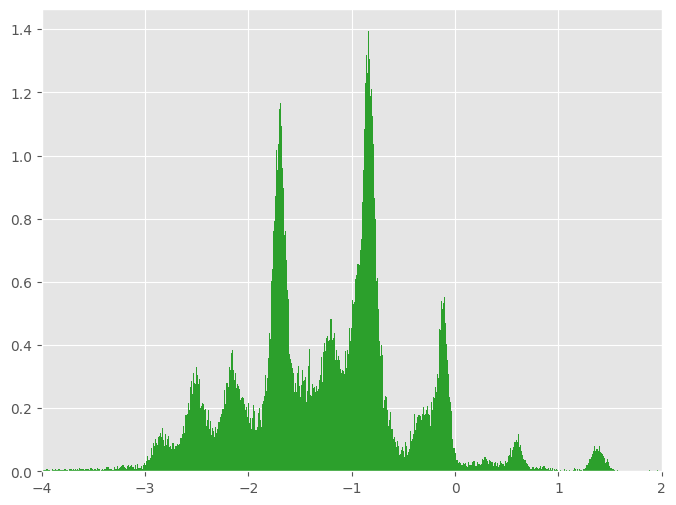

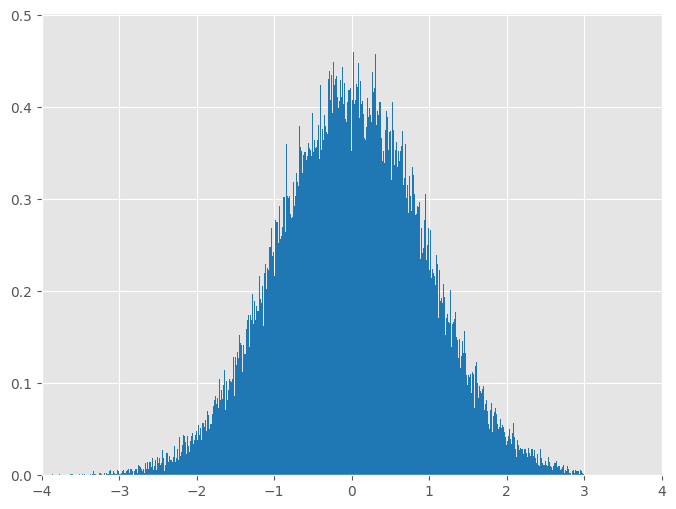

In [9]:
vals = list(df0.hc_greater) 
plt.hist(vals, bins = np.linspace(-4,3,1000), density=True, color='tab:green')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([-4, 2])


plt.savefig(output_dir + 'Figs/hc_hist.png')
plt.show()

vals = list(df0.log_rank_greater) 
plt.hist(vals, bins = np.linspace(-4,3,1000), density=True, color='tab:blue')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([-4, 4])

plt.savefig(output_dir + 'Figs/lr_hist.png')
plt.show()

### Test

In [160]:
# stat per gene

acc = []
df0n = pd.DataFrame()
for c in tqdm(df0.groupby('name')):
    df0n = df0n.append({
        'name': c[0],
        'q95': pd.Series.quantile(c[1].hc_greater, .95),
        'hc_mean': c[1].hc_greater.mean(),
        'hc_std': c[1].hc_greater.std(),
        'q95_log_rank': pd.Series.quantile(c[1].log_rank_greater, .95),
    }, ignore_index=True)
df0n = df0n.set_index('name')

100%|██████████| 9259/9259 [00:24<00:00, 376.18it/s]


In [15]:
from test_gene_expression import test_gene, q95

In [7]:
T = 100
M = 100000
stbl = False
df0 = pd.read_csv(f'results/SCNAB_null_False_T{T}_M{M}.csv')

crit_vals = df0.agg([q95]).filter(
        ['log_rank_greater', 
         'hc_greater', 
         'hc_greater_rev', 
         'log_rank_greater_rev'])
crit_vals

,log_rank_greater,hc_greater,hc_greater_rev,log_rank_greater_rev
q95,1.567429,-0.058408,-0.052623,1.552474


## Analyze Results

Use script in ``test_gene_expression.py`` to get the results

In [8]:
T = 100
stbl = False
res = pd.read_csv(f"results/SCNAB_greater_{stbl}_T{T}.csv")
#res = res[res.name.isin(gene_names)]

T = 100
stbl = True
res = pd.read_csv(f"SCANB_test_randomized_{stbl}_T{T}__randomized.csv")

In [30]:
# analyze results

LRt = crit_vals['log_rank_greater'].values[0]
HCt = crit_vals['hc_greater'].values[0]

HCt = 1.41188

log_rank_non = (res.log_rank_greater < LRt) & (res.log_rank_greater_rev < LRt)
log_rank_1side_strict = (res.log_rank_greater > LRt) & (res.log_rank_greater_rev < LRt)
log_rank_1side_strict_rev = (res.log_rank_greater < LRt) & (res.log_rank_greater_rev > LRt)
log_rank_2side = (res.log_rank_greater > LRt) | (res.log_rank_greater_rev > LRt)

log_rank_strict = log_rank_1side_strict | log_rank_1side_strict_rev

hc_non = (res.hc_greater < HCt) & (res.hc_greater_rev < HCt)
hc_1side_strict = (res.hc_greater > HCt) & (res.hc_greater_rev < HCt)
hc_1side_strict_rev = (res.hc_greater < HCt) & (res.hc_greater_rev > HCt)
hc_2side = (res.hc_greater > HCt) | (res.hc_greater_rev > HCt)

hc_strict = hc_1side_strict | hc_1side_strict_rev

print("Strictly one-sided effect:")
print("\tDiscoverable by HC: ", np.sum(hc_strict))
print("\tDiscoverable by LR: ", np.sum(log_rank_strict))

print("\tDiscoverable by HC and LR: ", np.sum(hc_strict & log_rank_strict))
print("\tDiscoverable by HC but not LR: ", np.sum(hc_strict & (1 - log_rank_strict) )   )
print("\tDiscoverable by LR but not HC: ", np.sum((1 - hc_strict) & ( log_rank_strict) )   )
print("\tDiscoverable by neigher HC nor LR: ", np.sum((1 - hc_strict) & (1 - log_rank_strict) )   )


print(" Either side effect:")

print("\tDiscoverable by HC: ", np.sum(hc_2side))
print("\tDiscoverable by LR: ", np.sum(log_rank_2side))


print("\tDiscoverable by HC and LR: ", np.sum(hc_2side & log_rank_2side))
print("\tDiscoverable by HC but not LR: ", np.sum(hc_2side & (1 - log_rank_2side) )   )
print("\tDiscoverable by LR but not HC: ", np.sum((1 - hc_2side) & ( log_rank_2side) )   )
print("\tDiscoverable by neigher HC nor LR: ", np.sum((1 - hc_2side) & (1 - log_rank_2side) )   )



Strictly one-sided effect:
	Discoverable by HC:  3670
	Discoverable by LR:  4564
	Discoverable by HC and LR:  3270
	Discoverable by HC but not LR:  400
	Discoverable by LR but not HC:  1294
	Discoverable by neigher HC nor LR:  3738
 Either side effect:
	Discoverable by HC:  3675
	Discoverable by LR:  4564
	Discoverable by HC and LR:  3270
	Discoverable by HC but not LR:  405
	Discoverable by LR but not HC:  1294
	Discoverable by neigher HC nor LR:  3733


### Arrange Results for presentation:

In [11]:
def empirical_pval(x, stat_name, df0):
    return np.minimum((np.sum(df0[stat_name].values >= x) ) / len(df0), 1)


# use minimal P-value between both sides
res['log_rank_pval'] = [empirical_pval(v, 'log_rank_greater', df0) for v in res['log_rank_greater'].values]
res['log_rank_rev_pval'] = [empirical_pval(v, 'log_rank_greater_rev', df0) for v in res['log_rank_greater_rev'].values]
res['hc_greater_pval'] = [empirical_pval(v, 'hc_greater', df0) for v in res['hc_greater'].values]
res['hc_greater_rev_pval'] = [empirical_pval(v, 'hc_greater_rev', df0) for v in res['hc_greater_rev'].values]
res['hc_pval'] = np.minimum(res['hc_greater_pval'], res['hc_greater_rev_pval'])
res['log_rank_pval'] = np.minimum(res['log_rank_pval'], res['log_rank_rev_pval'])
res['l-ratio'] = res['hc_pval'] / res['log_rank_pval']

In [12]:
# take only those discovered by HC but not LR:
resi = res[hc_strict & (1 - log_rank_strict)].sort_values('l-ratio').filter(['name', 'hc_greater', 'hc_greater_rev',
                                            'log_rank_greater', 'log_rank_greater_rev',
                                            'hc_pval', 'log_rank_pval', 'l-ratio'
                                           ])
len(resi) # 427

73

In [13]:
from illustrate_gene_expression_survival_curves import illustrate_survival_curve_gene, multi_pvals, find_changes

In [96]:
from test_gene_expression import test_gene

acc = []
nMonte = 1000
for _ in range(nMonte):
    r = test_gene(df, gene_name, T, stbl=True, randomize=True)
    acc.append(r['hc_greater'].values[0])

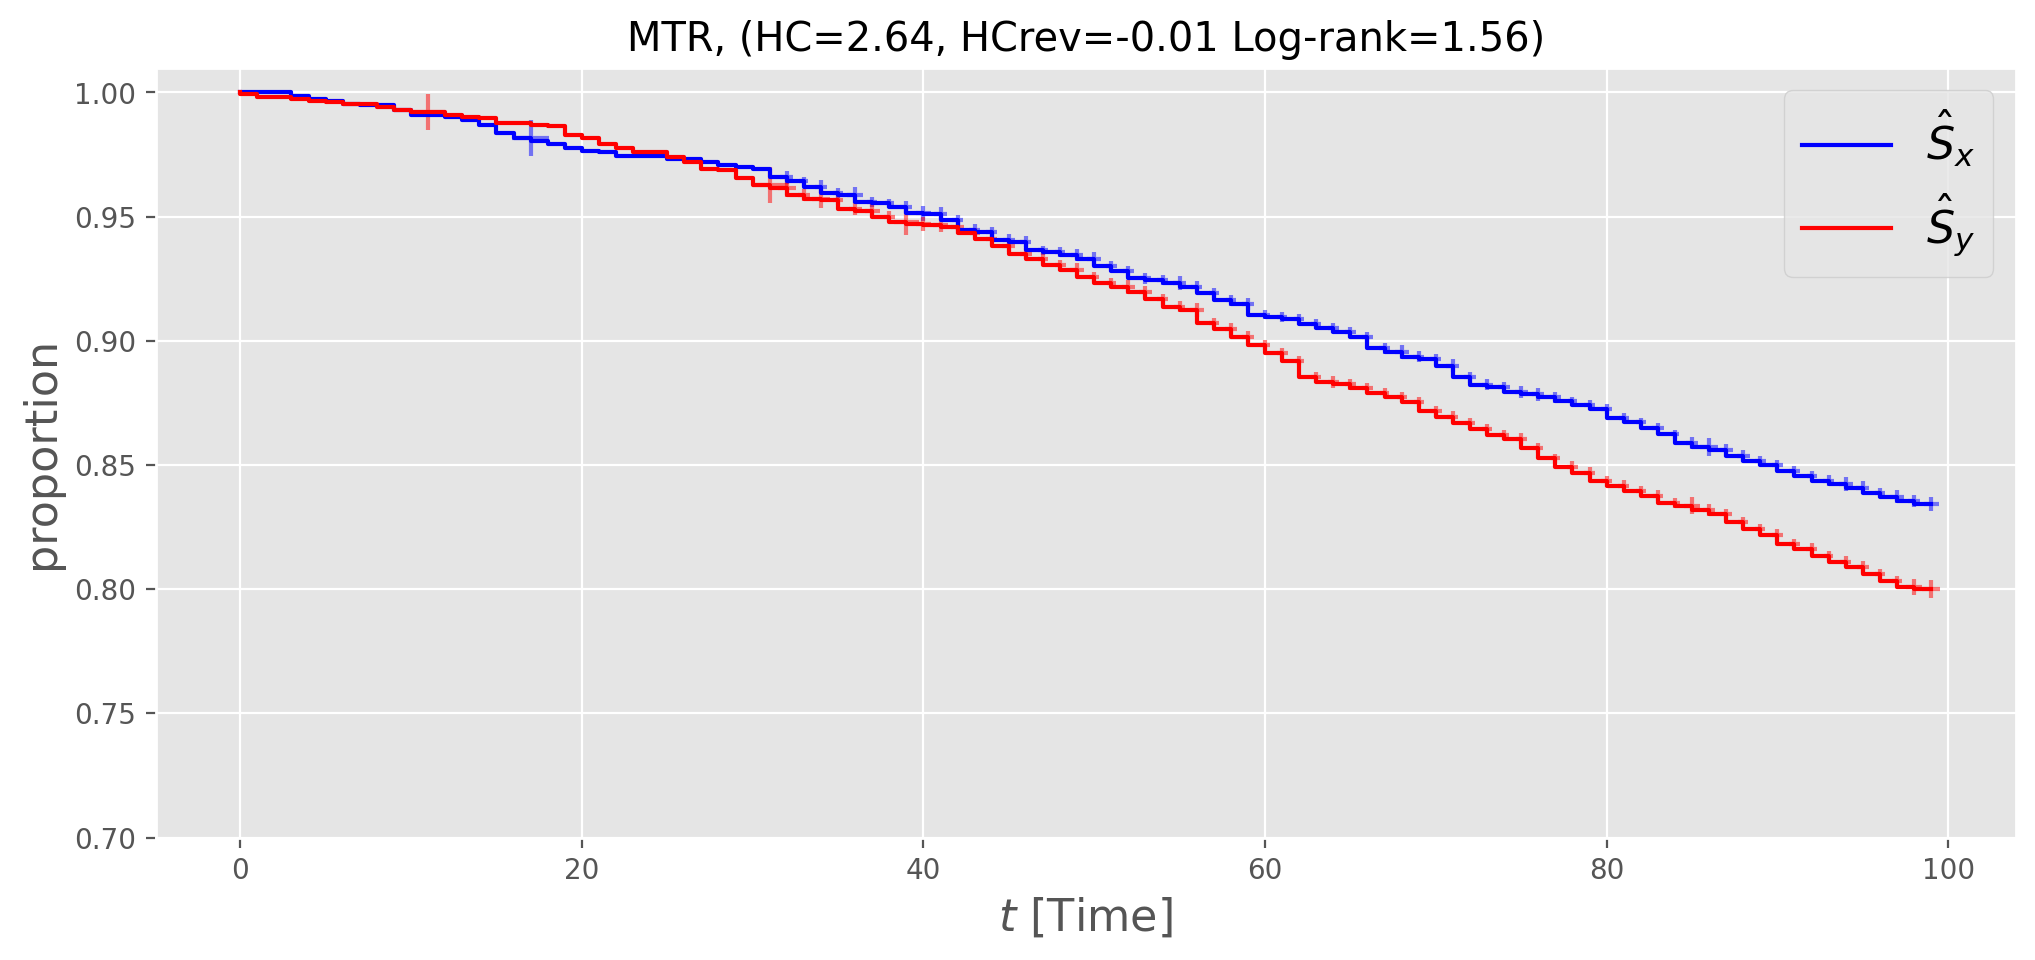

In [44]:
gene_name = 'MTR'
dfp, dfg = illustrate_survival_curve_gene(df, gene_name, T, stbl=False, show_HCT=False, randomize_HC=True)

In [45]:
dfp

,events X,events Y,censored1,censored2,at-risk X,at-risk Y,pvalue,pvalue_rev,Survival Proportion X,Survival Proportion Y
t,,,,,,,,,,
23,0.0,3.0,0.0,0.0,1494.0,1500.0,0.125627,1.000000,0.974560,0.977836
26,0.0,3.0,0.0,0.0,1492.0,1494.0,0.125126,1.000000,0.973255,0.973924
29,1.0,5.0,0.0,0.0,1488.0,1486.0,0.108824,0.984516,0.970646,0.968709
35,1.0,5.0,13.0,11.0,1441.0,1451.0,0.110760,0.984130,0.959677,0.956811
37,0.0,3.0,12.0,6.0,1418.0,1426.0,0.125926,1.000000,0.955812,0.952381
45,0.0,4.0,9.0,8.0,1319.0,1348.0,0.065119,1.000000,0.940416,0.938375
47,0.0,3.0,14.0,12.0,1295.0,1324.0,0.129054,1.000000,0.936404,0.933144
53,0.0,3.0,10.0,8.0,1221.0,1244.0,0.128378,1.000000,0.925134,0.919643
60,0.0,3.0,15.0,13.0,1134.0,1153.0,0.127976,1.000000,0.910496,0.898345


In [51]:
resm = pd.read_csv("SCANB_True_T100_randomized_rep100.csv")

def rate_succ(xx):
    t = 1.41
    return np.mean(xx > t)

hc_sum = resm.groupby('name').hc_greater.agg(['mean', q95, rate_succ])

hc_sum.sort_values('rate_succ', ascending=False).head(50)

,mean,q95,rate_succ
name,,,
MTR,2.142463,2.672658,0.99
TRPS1,2.181579,2.805051,0.96
C11orf68,1.988362,2.613434,0.94
HIST1H4A,1.934908,2.484923,0.93
FBXL12,1.940221,2.612060,0.92
CXCL6,1.933147,2.571837,0.92
PACS1,1.903438,2.415580,0.90
PMS2,1.975857,2.616273,0.90
GAB2,1.931782,2.530925,0.88


2it [00:00,  5.71it/s]


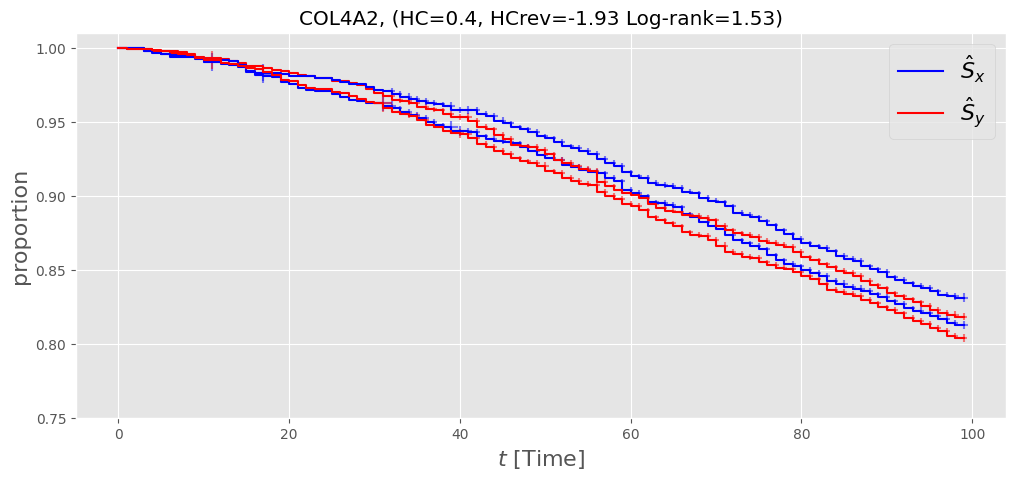

In [27]:
plt.rcParams['figure.figsize'] =  [12, 5]
resi['flip'] = resi.hc_greater_rev > resi.hc_greater
resi['hc'] = np.maximum(resi.hc_greater_rev, resi.hc_greater)

resi['no_p'] = 0
resi_sample = resi.sample(2)
for r in tqdm(resi_sample.iterrows()):
    gene_name = r[1]['name']
    dfp, dfg = illustrate_survival_curve(df, gene_name, T, stbl=False, show_HCT=False)
    resi.loc[r[0],'no_p'] = len(dfp)
plt.ylim([.75 ,1.01])
plt.show()

In [19]:
gene_name = 'TRPS1'
T = 100

from test_gene_expression import reduce_time_resolution, two_groups_gene
from survival import multi_pvals

dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)
Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values


def HCHG_survival_analysis(Nt1, Nt2, Ot1, Ot2, randomize=False, stbl=stbl):

    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=randomize)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) 
    hc, hct = mt.hc(gamma=.2)
    fisher = mt.fisher()
        
    fpval = pvals <= hct
    
    dfg['pvalue'] = pvals
    dfg['t'] = np.arange(0,len(Ot1))

    cumc1 = dfg['censored1'].cumsum()
    cumc2 = dfg['censored2'].cumsum()
    dfg['Survival Proportion X'] = (dfg['at-risk1'] - dfg['censored1']) / (dfg['at-risk1'].max() - cumc1)
    dfg['Survival Proportion Y'] = (dfg['at-risk2'] - dfg['censored2']) / (dfg['at-risk2'].max() - cumc2)
        
    dfg['suspected'] = fpval
    return dfg.set_index('t'), hc, fisher[0]

def HCHG_survival_analysis_full(Nt1, Nt2, Ot1, Ot2, randomize=False, stbl=stbl):
    
    dfg, hc, fisher = HCHG_survival_analysis(Nt1, Nt2, Ot1, Ot2, randomize=randomize, stbl=stbl)
    
    fpval = dfg.suspected
    plt.step(dfg.index, dfg['Survival Proportion X'], 'b', where='pre')
    plt.step(dfg.index, dfg['Survival Proportion Y'], 'r', where='pre')
    ct1 = dfg['censored1'] > 0
    ct2 = dfg['censored2'] > 0
    s1 = 10 * (dfg.loc[ct1, 'censored1'].max() / dfg.loc[ct1, 'censored1']).values
    s2 = 10 * (dfg.loc[ct2, 'censored2'].max() / dfg.loc[ct2, 'censored2']).values
    plt.scatter(dfg.index[ct1], dfg.loc[ct1,'Survival Proportion X'],
                marker='+', c='b',
                s=s1, alpha=.5)
    plt.scatter(dfg.index[ct2], dfg.loc[ct2,'Survival Proportion Y'],
                marker='+', c='r',
                s=s2, alpha=.5)
    
    plt.legend([r'$\hat{S}_x$', r'$\hat{S}_y$'], fontsize=16, loc=1)
    
    plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.5)

    plt.title(rf"{gene_name}: HCHG={np.round(hc,3)}, Fisher={np.round(fisher,3)}")
    plt.ylabel('Survival Proportion', fontsize=16)
    plt.xlabel(r'$t$ (Time)', fontsize=16)
    plt.ylim([0.7, 1.01])
    
    return dfg
    
dfg = HCHG_survival_analysis_full(Nt1, Nt2, Ot1, Ot2)
dfg

NameError: name 'df' is not defined

In [36]:
ls_rep = resi[resi['no_p'] >= 2].name.unique()
ls_rep

array(['DCK', 'ADSS', 'RCAN1', 'FNTA', 'SLCO3A1', 'ST6GALNAC5', 'KCTD9',
       'PIP5K1A', 'KLHL12', 'NFIB', 'KANK1', 'RGS14', 'VAMP4', 'ZMAT3',
       'SLC8A1', 'TMEM38B', 'HIST1H3G', 'CTNNA1', 'SIGMAR1', 'RNF7',
       'PPFIBP2', 'SPAG9', 'UXT', 'SLC5A12', 'NTF3', 'EDC3', 'MED17',
       'FHL2', 'CATSPER2', 'PLCG2', 'EPB41L5', 'DIRAS2', 'ATG7', 'LRRC41',
       'FBXO41', 'PKDREJ', 'NUDT13', 'CANT1', 'MYO18A', 'STX3', 'ECHDC1',
       'CERS2', 'HIST1H4B', 'PKNOX2', 'TMSB15B', 'C11orf68', 'OS9',
       'PREPL', 'MRPS28', 'NUP188', 'FURIN', 'RBPJ', 'KPNB1', 'ITPKC',
       'SEC22A', 'POLDIP3', 'POLD4', 'NIT1', 'CCHCR1', 'OLAH', 'SCRG1',
       'BCLAF1', 'SNAPC5', 'RAD21', 'HNRNPA3', 'PID1', 'SMG9', 'ZNF778',
       'CCL20', 'NAIP', 'TESK1', 'CCL2', 'CREB3L1', 'TUBAL3', 'NFE2L3',
       'RHOQ', 'HTR3B', 'UCK2', 'MCAT', 'GRWD1', 'NIPSNAP1', 'DYRK4',
       'TIMM8B', 'IFNAR2', 'ICAM1', 'AKR1B1', 'PAPSS1', 'SARDH',
       'CATSPERB', 'FBXL12', 'ERGIC3', 'BCL9', 'PTPRJ', 'RBP1',
       'TNFR

In [39]:
# select 10 and add two presented genes. 
in_paper = ['SIGMAR1', 'ST6GALANC5', 'DCK', 'ADSS', 'KCTD9', 'VAMP4', 'HIST1H3G', 'TMEM38B', 'SIGMAR1', 'SMG9', 'FBXL12', 'PDE6D', 'BTNL8']
top_10 = resi[resi.name.isin(ls_rep)].sort_values('hc_greater', ascending=False).groupby('flip').head(5).name
resi_disp = resi[resi.name.isin(in_paper + list(top_10))]

In [17]:
resi.sort_values('hc_greater', ascending=False).head(5)

,name,hc_greater,hc_greater_rev,log_rank_greater,log_rank_greater_rev,hc_pval,log_rank_pval,l-ratio
7979,TRPS1,2.227933,0.627983,1.254463,-1.254463,0.00003,0.09316,0.000322
4631,MTR,2.174950,0.463798,1.562535,-1.562535,0.00003,0.05045,0.000595
5705,PPFIBP2,1.961168,1.300029,0.418333,-0.418333,0.00011,0.33100,0.000332
5619,PMS2,1.949112,0.792669,1.475881,-1.475881,0.00014,0.05995,0.002335
1782,CXCL6,1.933868,0.551772,1.315574,-1.315574,0.00015,0.08304,0.001806


In [47]:
print("Saving SCANB results...")
path = remote_dir + "csv/results_SCANB.csv"

def prepare_for_display(resi_disp):
    flip_idc = resi_disp['hc_greater'] < resi_disp['hc_greater_rev']
    resi_disp['flip'] = '$>$ med'
    resi_disp.loc[flip_idc, 'flip'] = '$<$ med'
    resi_disp['hc'] = np.maximum(resi_disp['hc_greater'], resi_disp['hc_greater_rev'])
    resi_disp['log_rank'] = np.maximum(resi_disp['log_rank_greater'], resi_disp['log_rank_greater_rev'])
    rr = resi_disp.reset_index().filter(['name', 'hc', 'hc_pval', 'log_rank', 'log_rank_pval', 'flip'])

    return rr[rr['log_rank'] > 0.05]

df_disp = prepare_for_display(resi_disp).set_index('name')

print(resi_disp[['name', 'hc_pval', 'log_rank_pval', 'flip']].rename(
    columns={'name': 'Gene Name', 'hc_pval':'HC (P-value)', 'log_rank_pval':'Log-rank (P-value)', 'flip': 'Increased Mortality'})\
        .set_index('Gene Name').to_latex())
df_disp.to_csv(path)
print(f"saved to {path}")


Saving SCANB results...
\begin{tabular}{lrrl}
\toprule
{} &  HC (P-value) &  Log-rank (P-value) & Increased Mortality \\
Gene Name &               &                     &                     \\
\midrule
DCK       &       0.00010 &             0.35505 &             \$>\$ med \\
ADSS      &       0.00005 &             0.05483 &             \$>\$ med \\
KCTD9     &       0.01284 &             0.33369 &             \$>\$ med \\
VAMP4     &       0.01271 &             0.20006 &             \$>\$ med \\
TMEM38B   &       0.02857 &             0.41772 &             \$<\$ med \\
HIST1H3G  &       0.02725 &             0.39828 &             \$<\$ med \\
SIGMAR1   &       0.01180 &             0.15812 &             \$<\$ med \\
POLDIP3   &       0.04683 &             0.33744 &             \$<\$ med \\
SMG9      &       0.03775 &             0.22874 &             \$<\$ med \\
FBXL12    &       0.01266 &             0.05641 &             \$>\$ med \\
BTNL8     &       0.03934 &             0.05110

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_49045/3356553422.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resi_disp['flip'] = '$>$ med'
/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_49045/3356553422.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resi_disp['hc'] = np.maximum(resi_disp['hc_greater'], resi_disp['hc_greater_rev'])
/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_49045/3356553422.py:9: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [18]:
remote_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/"

plt.rcParams['figure.figsize'] =  [12, 6]
plt.rcParams["figure.dpi"] = 200

list_to_plot = resi_disp.name.values
list_to_plot = ['TRPS1']

for gene_name in list_to_plot:
    df_disp, dfp = illustrate_survival_curve(df, df0, gene_name, T, stbl=True)
    plt.savefig(remote_dir + "Figs/"  + gene_name + ".png")
    plt.show()

    dfd = df_disp.copy()
    dfd = dfd.iloc[:, :-2]

    for tag in ['pvalue', 'pvalue_rev']:
        dfd[tag] = np.round(dfd[tag],3)

    for tag in ['at-risk X', 'at-risk Y', 'events X', 'events Y']:
        dfd[tag] = dfd[tag].astype(int)

    dfd.index.name = 'time'

    dfd.filter(['at-risk X', 'at-risk Y', 'events X', 'events Y', 'pvalue', 'pvalue_rev'])\
        .to_csv(remote_dir + "csv/" + f'{gene_name}.csv')


NameError: name 'resi_disp' is not defined

Saving SCANB results...
saved to /Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/csv/results_SCANB.csv


<ipython-input-63-969544c7c75e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resi_disp['flip'] = '$>$ med'
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-63-969544c7c75e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat